In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import make_scorer, roc_auc_score
from catboost import CatBoostClassifier, Pool
from catboost.text_processing import Tokenizer, Dictionary
from copy import deepcopy
from nltk.tokenize import MWETokenizer
import sqlite3
import sys
import ctypes
import gc
import joblib
import numpy as np
import pandas as pd
import catboost
import heapq
import pickle
import warnings
import random
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
warnings.filterwarnings('ignore')
random.seed(37)

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikitadanilov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load dataset

In [6]:
df = pd.read_csv('../train/codevsotherv1.csv')

In [7]:
df = df[df['language'] != 'OTHER'] # only code languages

In [11]:
df

,snippet,language,group
0,"*/\n\n#include <unistd.h>\n#include ""global-c...",C,train
1,* the Free Softwa,C,train
2,*\tr)\thome directory\n */\nchar *\nget_home_...,C,train
3,* mpool_open --\n *\tInitialize a memory pool...,C,test
4,#define XSTR(x)\t\t\tSTR(x)\n#define PRECISION...,C,test
...,...,...,...
844001,\nint test_inlineref(int x,FUNC,train
844002,".store_int(0, 1); ;; empty...",FUNC,test
844003,\nconst int WOR,FUNC,train
844004,request#_ valid,FUNC,train


In [12]:
df['group'] = df['snippet'].apply(
    lambda x: 'train' 
    if random.random() < 0.8  
    else 'test'
)

In [13]:
df.groupby('language').count().sort_values(by='snippet', ascending=False).reset_index()

,language,snippet,group
0,JSON,34991,34991
1,XML,34973,34973
2,TYPESCRIPT,34966,34966
3,SQL,34961,34961
4,POWERSHELL,34958,34958
5,GO,34958,34958
6,RUST,34957,34957
7,JAVASCRIPT,34956,34956
8,CSHARP,34954,34954
9,CPLUSPLUS,34954,34954


### Check split by train/test and by language

In [14]:
def sample_group(group, num):
    return group.sample(min(len(group), num))

NUM = 1854392
# Apply the function to each group
train = df[df.group == 'train'].groupby('language', group_keys=False).apply(lambda x: sample_group(x, num=NUM*0.8)).reset_index(drop=True)
test = df[df.group == 'test'].groupby('language', group_keys=False).apply(lambda x: sample_group(x, num=NUM*0.2)).reset_index(drop=True)
# Display the sampled DataFrame

In [15]:
train

,snippet,language,group
0,*\n * Since t,C,train
1,#ifndef __ARCH_H8300_CACHE_H\n#define,C,train
2,"/*\n * (C) Copyright 2011, Stefan Kristiansson...",C,train
3,/* { dg-do compile } */\n\ninline void *operat...,C,train
4,\t\t\t\telse\n\t\t\t\t{\n,C,train
...,...,...,...
674890,\t\t\t\t\t\t\t\t\t(to which application will b...,XML,train
674891,"<project xmlns=""http://maven.apache.org/POM/4....",XML,train
674892,<?xml vers,XML,train
674893,"\t\t\t<revision name=""2.1.0"" status=""release"" ...",XML,train


In [16]:
meta = []
for language in df.language.unique():
    len_train = len(train[train.language == language])
    len_test = len(test[test.language == language])
    meta.append((len_train + len_test, len_train / (len_train + len_test), language))
df_meta = pd.DataFrame(meta, columns=['num', 'train_share', 'language'])
df_meta.sort_values('num', ascending=False).reset_index()

,index,num,train_share,language
0,8,34991,0.798148,JSON
1,23,34973,0.801561,XML
2,22,34966,0.805525,TYPESCRIPT
3,19,34961,0.797088,SQL
4,6,34958,0.799731,GO
5,15,34958,0.799502,POWERSHELL
6,18,34957,0.798753,RUST
7,10,34956,0.800092,JAVASCRIPT
8,2,34954,0.799393,CPLUSPLUS
9,12,34954,0.799165,LUA


Text(0.5, 1.0, 'Distribution of Text Lengths')

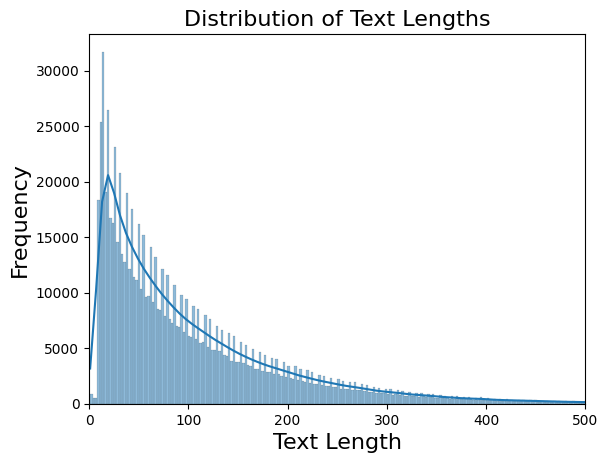

In [25]:
sns.histplot(df[df.language != 'OTHER']['snippet'].apply(len), kde=True, bins=500)  # You can adjust the number of bins as needed

# Set plot labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 500)
plt.title('Distribution of Text Lengths')

### Grid search by parameters. Catboost classifier with tokenizer

In [74]:
import gc 

tokenizer = Tokenizer(
    lowercasing=True, 
    separator_type='BySense', 
    token_types=['Word', 'Number', 'Punctuation', 'SentenceBreak', 'ParagraphBreak', 'Unknown']
)

train_pool = Pool(
    data=train['snippet'],
    label=train['language'],
    text_features=['snippet'],
    feature_names=['snippet']
)

test_pool = Pool(
    data=test['snippet'],
    label=test['language'],
    text_features=['snippet'],
    feature_names=['snippet']
)
VOCAB_GRID = ["5000"]#, "1500"]#["500", "1500", "5000"]
DEPTH_GRID = [9]#[7, 9, 11]
for DEPTH in DEPTH_GRID:
    for VOCAB in VOCAB_GRID:
        print(DEPTH, VOCAB)
        cat_model = CatBoostClassifier(
            iterations=300,
            eval_metric='Accuracy',
            early_stopping_rounds=20,
            depth=DEPTH,
            auto_class_weights='Balanced',
            # class_weights={'OTHER': 0.9, 'CODE': 0.1},
            used_ram_limit='60gb',
            thread_count=-1,
            text_processing = {
                "tokenizers" : [{
                    "tokenizer_id" : "Space",
                    "token_types" : ['Word', 'Number', 'Punctuation', 'SentenceBreak', 'ParagraphBreak', 'Unknown'],
                    "lowercasing" : "true",
                    "separator_type" : "BySense",
                    "number_process_policy" : "Replace",
                    "number_token" : "123",
                }],
        
                "dictionaries" : [{
                    "dictionary_id" : "Word",
                    "occurrence_lower_bound": "7",
                    "max_dictionary_size": VOCAB,
                    "gram_order" : "1",
                    "dictionary_type": "Bpe"
                }],
        
                "feature_processing" : {
                    "default" : [{
                        "tokenizers_names" : ["Space"],
                        "dictionaries_names" : ["Word"],
                        "feature_calcers" : ["BoW"] #BoW:top_tokens_count=1000
                    }],
                }
            }
        )
        cat_result = cat_model.fit(
            train_pool,
            plot=True,
            use_best_model=True,
            eval_set=test_pool
        )
        print('train {}'.format(accuracy_score(cat_result.predict(train_pool), train.language)))
        print('test {}'.format(accuracy_score(cat_result.predict(test_pool), test.language)))
        display(pd.DataFrame(classification_report(cat_result.predict(test_pool), test.language, output_dict=True)).transpose())
        cat_result.save_model('../resources/v1_languages_depth{}_vocab{}.cbm'.format(DEPTH, VOCAB), pool=train_pool, format='cbm')
        # del cat_result
        # gc.collect()

9 5000


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.194828
0:	learn: 0.2300485	test: 0.2269194	best: 0.2269194 (0)	total: 10.4s	remaining: 51m 48s
1:	learn: 0.3339658	test: 0.3307961	best: 0.3307961 (1)	total: 21s	remaining: 52m 9s
2:	learn: 0.3917167	test: 0.3892271	best: 0.3892271 (2)	total: 31.8s	remaining: 52m 23s
3:	learn: 0.4321935	test: 0.4274012	best: 0.4274012 (3)	total: 42.5s	remaining: 52m 22s
4:	learn: 0.4581579	test: 0.4509717	best: 0.4509717 (4)	total: 52.6s	remaining: 51m 45s
5:	learn: 0.4767726	test: 0.4721315	best: 0.4721315 (5)	total: 1m 3s	remaining: 51m 43s
6:	learn: 0.4924899	test: 0.4877876	best: 0.4877876 (6)	total: 1m 14s	remaining: 51m 37s
7:	learn: 0.5046425	test: 0.4990290	best: 0.4990290 (7)	total: 1m 24s	remaining: 51m 41s
8:	learn: 0.5141466	test: 0.5067683	best: 0.5067683 (8)	total: 1m 35s	remaining: 51m 22s
9:	learn: 0.5258876	test: 0.5193722	best: 0.5193722 (9)	total: 1m 46s	remaining: 51m 22s
10:	learn: 0.5367337	test: 0.5299120	best: 0.5299120 (10)	total: 1m 57s	remaining: 51m 17

,precision,recall,f1-score,support
C,0.614465,0.536749,0.572984,8041.000000
CPLUSPLUS,0.473331,0.614175,0.534633,5404.000000
CSHARP,0.711399,0.718713,0.715037,6808.000000
CSS,0.872410,0.704043,0.779236,8731.000000
DART,0.681407,0.746017,0.712250,6465.000000
DOCKER,0.882869,0.877415,0.880133,6314.000000
FUNC,0.741667,0.113956,0.197558,781.000000
GO,0.749179,0.734697,0.741867,7139.000000
HTML,0.799601,0.874513,0.835381,6415.000000
JAVA,0.616588,0.744034,0.674343,5825.000000


### Check model quality (75% accuracy on all dataset)

In [23]:
cat_result = CatBoostClassifier()  
cat_result = cat_result.load_model('../resources/v1_languages_depth9_vocab5000.cbm', format='cbm')
cat_result.classes_

array(['C', 'CPLUSPLUS', 'CSHARP', 'CSS', 'DART', 'DOCKER', 'FUNC', 'GO',
       'HTML', 'JAVA', 'JAVASCRIPT', 'JSON', 'KOTLIN', 'LUA', 'NGINX',
       'OBJECTIVE_C', 'PHP', 'POWERSHELL', 'PYTHON', 'RUBY', 'RUST',
       'SHELL', 'SOLIDITY', 'SQL', 'SWIFT', 'TL', 'TYPESCRIPT', 'XML'],
      dtype=object)

In [17]:
train_pool = Pool(
    data=df['snippet'],#[0:100],#[0:100],
    text_features=['snippet'],
    feature_names=['snippet']
)

In [19]:
print('train {}'.format(accuracy_score(cat_result.predict(train_pool), df.language)))
display(pd.DataFrame(classification_report(cat_result.predict(train_pool), df.language, output_dict=True)).transpose())

train 0.7532861140797578


,precision,recall,f1-score,support
C,0.637435,0.555683,0.593758,40093.000000
CPLUSPLUS,0.491017,0.642978,0.556815,26693.000000
CSHARP,0.722922,0.736040,0.729422,34331.000000
CSS,0.874907,0.707709,0.782476,43207.000000
DART,0.686906,0.748060,0.716180,32091.000000
DOCKER,0.885588,0.879652,0.882610,31924.000000
FUNC,0.891680,0.139867,0.241805,4061.000000
GO,0.746725,0.734765,0.740697,35527.000000
HTML,0.806679,0.879238,0.841397,32063.000000
JAVA,0.618581,0.745087,0.675966,29006.000000


### Check Accuracy vs Snippet length

In [28]:
test_pool = Pool(
    data=test['snippet'],#[0:100],#[0:100],
    text_features=['snippet'],
    feature_names=['snippet']
)
test['predict'] = [x[0] for x in cat_result.predict(test_pool)]
test['length'] = test['snippet'].apply(lambda x: len(x.lstrip().rstrip()))

In [30]:
scores = []
for bin in range(10):
    accuracy = accuracy_score(
        test[(bin * 20 < test['length']) & (test['length'] < bin * 20 + 20)]['predict'], 
        test[(bin * 20 < test['length']) & (test['length'] < bin * 20 + 20)].language
    )
    length = bin * 20
    scores.append([length, accuracy])

In [38]:
df_scores = pd.DataFrame(scores, columns=['Length of Snippet', 'Accuracy'])

<Axes: xlabel='Length of Snippet', ylabel='Accuracy'>

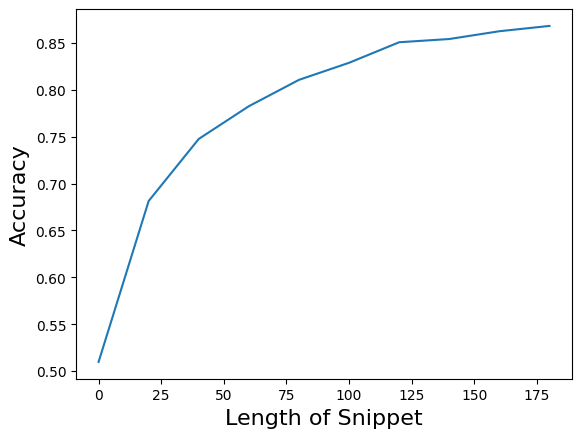

In [39]:
sns.lineplot(df_scores, x="Length of Snippet", y="Accuracy")